In [443]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import spikeinterface as si
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages


In [444]:
used_neurons = ['Neuron_2', 'Neuron_3', "Neuron_4", "Neuron_5", "Neuron_6", "Neuron_8", "Neuron_10",
                  'Neuron_7', 'Neuron_9', 'Neuron_12', "Neuron_14",
                  'Neuron_16', "Neuron_17", "Neuron_18",
                  "Neuron_19", "Neuron_20", 'Neuron_21', 'Neuron_22',
                  "Neuron_23", "Neuron_24", "Neuron_25"]

spike_inf = pd.read_csv("/media/ubuntu/sda/data/mouse6/output_grating/02_merge_new/spike_inf_refinhe.tsv", sep = '\t')
cluster_inf = pd.read_csv("/media/ubuntu/sda/data/mouse6/output_grating/02_merge_new/clusteri_inf_refinhe.tsv", sep = '\t')

In [445]:
trigger_time = pd.read_csv("/media/ubuntu/sda/data/mouse6/output_grating/01_get_trigger/trigger_time_static.tsv", sep = '\t').iloc[:, 1:]

import pickle
with open('/media/ubuntu/sda/data/mouse6/output_grating/02_merge_new/outlier_static.pkl', 'rb') as f:
    outlier = pickle.load(f)


In [446]:
trigger_time['start'] = trigger_time['start'] + 1300 * 10000
trigger_time['expand_end'] = trigger_time['start'] + 15000
trigger_time['end'] = trigger_time['start'] +10000
trigger_time['expand_start'] = trigger_time['start'] - 5000

In [447]:
for i in outlier:
    date = i.split("_")[0]
    image = i.split("_")[1] + "_" + i.split("_")[2]
    trigger_time = trigger_time[~((trigger_time['date'] == int(date)) & (trigger_time['order'] == image))]

In [448]:
date_order = ['021322',  '022522', '031722', '052422', '062422', '072322', '082322', '092422', '102122', '112022', '022223', '032123', '042323', '042422']

In [449]:
trigger_time = trigger_time[trigger_time['date'] != 21322]

In [130]:
with PdfPages("raster_overall.pdf") as pdf:
    for neuron in spike_inf['Neuron'].unique():
        neuron_df = spike_inf[spike_inf['Neuron'] == neuron]

        fig, ax = plt.subplots(figsize = (12, 7.5))
        for index, row in trigger_time.iterrows():
            date = row['date']
            image_order = row['order']
            start = row['expand_start'] 
            end = row['expand_end']
            
            filtered_spikes = neuron_df[(neuron_df['date'] == date) & 
                                        (neuron_df['time'] >= start) & 
                                        (neuron_df['time'] <= end)]
            
            if not filtered_spikes.empty:
                ax.plot(filtered_spikes['time'] - start, [index] * len(filtered_spikes), marker='|', mew=1, markersize=3, ls='', color='k')

        ax.set_yticks([])
        #ax.axvspan(1 + (5000 - 1) * 0.5, 1 + (5000 - 1), color='gray', alpha=0.3)

        ax.set_xlabel('time (s)')
        ax.set_ylabel("")
        ax.set_title(f'Raster Plot for {neuron}')

        pdf.savefig(fig)
        plt.close()

In [27]:
with PdfPages("raster_split_image.pdf") as pdf:
    for neuron in spike_inf['Neuron'].unique():
        neuron_df = spike_inf[spike_inf['Neuron'] == neuron]


        fig, axs = plt.subplots(3, 6, figsize=(30, 15), sharex=True, sharey=True)
        fig.subplots_adjust(hspace=0.5, wspace=0.5)

        for image in range(1, 19):  
            ax = axs[(image - 1) // 6, (image - 6) % 6]  
            trigger_time_temp = trigger_time[trigger_time['image'] == image]

            for index, row in trigger_time_temp.iterrows():
                date = row['date']
                image_order = row['order']
                start = row['expand_start'] 
                end = row['expand_end'] 

                filtered_spikes = neuron_df[(neuron_df['date'] == date) & 
                                            (neuron_df['time'] >= start) & 
                                            (neuron_df['time'] <= end)]

                if not filtered_spikes.empty:
                    ax.plot(filtered_spikes['time'] - start, [index] * len(filtered_spikes), 
                            marker='|', mew=1, markersize=3, ls='', color='k')


            ax.set_xticks([])
            ax.set_yticks([])

        pdf.savefig(fig)
        plt.close()

In [20]:
mean_spike_rate_dict = {}

with PdfPages("peth_lineplot_all.pdf") as pdf:
    for neuron in spike_inf['Neuron'].unique():
        plt.figure(figsize=(4, 2.5))
        spike_rates_all = np.empty((99))

        for image in range(1, 13):
            neuron_df = spike_inf[spike_inf['Neuron'] == neuron]

            dates = trigger_time[trigger_time['image'] == image]['date'].unique()
            date_indices = np.arange(len(dates))  

            spike_rates = []
            std_rates = []

            for date in dates:
                trigger_time_temp = trigger_time[(trigger_time['image'] == image) & (trigger_time['date'] == date)]
                all_spikes = []

                for index, row in trigger_time_temp.iterrows():
                    start = row['expand_start'] 
                    end = row['expand_end']

                    filtered_spikes = neuron_df[(neuron_df['date'] == date) &
                                                (neuron_df['time'] >= start) &
                                                (neuron_df['time'] <= end)]

                    if not filtered_spikes.empty:
                        relative_spikes = filtered_spikes['time'] - start
                        all_spikes.extend(relative_spikes)

                if all_spikes:
                    time_bins = np.linspace(0, max(all_spikes), 100)
                    spike_counts, _ = np.histogram(all_spikes, bins=time_bins)
                    spike_rate = spike_counts / (time_bins[1] - time_bins[0])
                    spike_rates.append(spike_rate)
                spike_rates_all = np.vstack((spike_rates_all, spike_rates))

        mean_spike_rate = np.mean(spike_rates, axis=0)
        std_spike_rate = np.std(spike_rates, axis=0)

        plt.plot(time_bins[:-1], mean_spike_rate, color='k', linewidth = 2)
        plt.plot(time_bins[:-1], mean_spike_rate - std_spike_rate, color='lightgray', alpha=0.7, linewidth = 1)
        plt.plot(time_bins[:-1], mean_spike_rate + std_spike_rate, color='lightgray', alpha=0.7, linewidth = 1)
        plt.title(neuron)
        plt.xticks([])
        plt.yticks([])
        pdf.savefig()
        plt.close()

In [39]:
from scipy import stats

num_neurons = len(spike_inf['Neuron'].unique())
num_images = 18
result_matrix = np.zeros((num_neurons, num_images), dtype=int)
pvalue_matrix = np.ones((num_neurons, num_images))

for image in range(1, 19):
    num = 0
    image_mean_spike_rate_data = []
    for neuron_idx, neuron in enumerate(spike_inf['Neuron'].unique()):

        neuron_df = spike_inf[spike_inf['Neuron'] == neuron]

        dates = trigger_time[trigger_time['image'] == image]['date'].unique()
        date_indices = np.arange(len(dates))  

        spike_rates = []
        std_rates = []

        for date in dates:
            trigger_time_temp = trigger_time[(trigger_time['image'] == image) & (trigger_time['date'] == date)]
            all_spikes = []

            for index, row in trigger_time_temp.iterrows():
                start = row['expand_start'] 
                end = row['expand_end'] - 10000

                filtered_spikes = neuron_df[(neuron_df['date'] == date) &
                                            (neuron_df['time'] >= start) &
                                            (neuron_df['time'] <= end)]

                if not filtered_spikes.empty:
                    relative_spikes = filtered_spikes['time'] - start
                    all_spikes.extend(relative_spikes)

            if all_spikes:
                time_bins = np.linspace(0, max(all_spikes), 100)
                spike_counts, _ = np.histogram(all_spikes, bins=time_bins)
                spike_rate = spike_counts / (time_bins[1] - time_bins[0])
                spike_rates.append(spike_rate)

        mean_spike_rate = np.mean(spike_rates, axis=0)
        std_spike_rate = np.std(spike_rates, axis=0)

        image_mean_spike_rate_data.append({
            'Neuron': neuron,
            'Mean_Spike_Rate': mean_spike_rate
        })

        num += 1

        first_half = mean_spike_rate[:50]
        second_half = mean_spike_rate[50:]

        t_stat, p_value = stats.ttest_ind(first_half, second_half)

        if p_value < 0.05:
            if np.mean(first_half) > np.mean(second_half):
                result_matrix[neuron_idx, image-1] = -1
            else:
                result_matrix[neuron_idx, image-1] = 1
        else:
            result_matrix[neuron_idx, image-1] = 0
        pvalue_matrix[neuron_idx, image-1] = p_value


neurons = spike_inf['Neuron'].unique()
images = range(1, 19)
result_df = pd.DataFrame(result_matrix, index=neurons, columns=images)
pvalue_df = pd.DataFrame(pvalue_matrix, index=neurons, columns=images)


In [40]:
result_df = result_df[[1, 7, 13, 2, 8, 14, 3, 9, 15, 4, 10, 16, 5, 11, 17, 6, 12, 18]]
pvalue_df = pvalue_df[[1, 7, 13, 2, 8, 14, 3, 9, 15, 4, 10, 16, 5, 11, 17, 6, 12, 18]]

In [41]:
from matplotlib.colors import ListedColormap

with PdfPages("neuron_reaction.pdf") as pdf:
    cmap = ListedColormap(['#6AA3CD', '#D1DED7', '#D78645'])
    plt.figure(figsize=(4, 4))
    ax = sns.heatmap(result_df, cmap=cmap, cbar=True)
    pdf.savefig()
    plt.close()

    cmap = ListedColormap(['#619DB8', '#ECF4DD', '#E87651'])
    plt.figure(figsize=(4, 4))
    ax = sns.heatmap(result_df, cmap=cmap, cbar=False, linecolor="white",   
    linewidths=0.5)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.axis('off') 
    pdf.savefig()
    plt.close()

    plt.figure(figsize=(4, 4))
    ax = sns.heatmap(-np.log(pvalue_df), cmap='coolwarm', cbar=True, annot=True,fmt='.2f',
    annot_kws={"size": 4})
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.axis('off') 
    pdf.savefig()
    plt.close()

    plt.figure(figsize=(4, 4))
    ax = sns.heatmap(-np.log(pvalue_df), cmap='coolwarm', cbar=False, annot=True,fmt='.2f',
    annot_kws={"size": 4})
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.axis('off') 
    pdf.savefig()
    plt.close()

In [42]:
mean_spike_rate_dict = {}

with PdfPages("peth_lineplot.pdf") as pdf:
    for image in range(1, 19):
        fig, axes = plt.subplots(3, 7, figsize=(15, 9))
        axes = axes.flatten()
        num = 0
        image_mean_spike_rate_data = []
        for neuron in spike_inf['Neuron'].unique():
            ax = axes[num]
            neuron_df = spike_inf[spike_inf['Neuron'] == neuron]

            dates = trigger_time[trigger_time['image'] == image]['date'].unique()
            date_indices = np.arange(len(dates))  

            spike_rates = []
            std_rates = []

            for date in dates:
                trigger_time_temp = trigger_time[(trigger_time['image'] == image) & (trigger_time['date'] == date)]
                all_spikes = []

                for index, row in trigger_time_temp.iterrows():
                    start = row['expand_start']
                    end = row['expand_end']

                    filtered_spikes = neuron_df[(neuron_df['date'] == date) &
                                                (neuron_df['time'] >= start) &
                                                (neuron_df['time'] <= end)]

                    if not filtered_spikes.empty:
                        relative_spikes = filtered_spikes['time'] - start
                        all_spikes.extend(relative_spikes)

                if all_spikes:
                    time_bins = np.linspace(0, max(all_spikes), 100)
                    spike_counts, _ = np.histogram(all_spikes, bins=time_bins)
                    spike_rate = spike_counts / (time_bins[1] - time_bins[0])
                    spike_rates.append(spike_rate)

            mean_spike_rate = np.mean(spike_rates, axis=0)
            std_spike_rate = np.std(spike_rates, axis=0)

            image_mean_spike_rate_data.append({
                'Neuron': neuron,
                'Mean_Spike_Rate': mean_spike_rate
            })

            ax.plot(time_bins[:-1], mean_spike_rate, color='k', linewidth = 2)
            ax.plot(time_bins[:-1], mean_spike_rate - std_spike_rate, color='lightgray', alpha=0.7, linewidth = 1)
            ax.plot(time_bins[:-1], mean_spike_rate + std_spike_rate, color='lightgray', alpha=0.7, linewidth = 1)
            #ax.set_ylim(- np.mean(mean_spike_rate) , 2 *np.mean(mean_spike_rate))
            #ax.fill_between(time_bins[:-1], mean_spike_rate - std_spike_rate, mean_spike_rate + std_spike_rate, color='lightgray', alpha=0.5, label='Std Deviation')
            quarter = (time_bins[-1] - time_bins[0]) * 0.25 + time_bins[0]
            three_quarter = (time_bins[-1] - time_bins[0]) * 0.75 + time_bins[0]
            ax.annotate("", xy=(quarter, np.max(mean_spike_rate + std_spike_rate) * 0.9), xytext=(quarter, np.max(mean_spike_rate + std_spike_rate)),
                        arrowprops=dict(arrowstyle="-|>", color="black"))
            ax.annotate("", xy=(three_quarter, np.max(mean_spike_rate + std_spike_rate) * 0.9), xytext=(three_quarter, np.max(mean_spike_rate + std_spike_rate)),
                        arrowprops=dict(arrowstyle="-|>", color="black"))
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_title(f'{neuron}', fontsize=10)
            ax.legend()

            ax.set_xticks([])
            ax.set_yticks([])
            ax.grid(False)
            ax.legend().set_visible(False)
            num += 1
        axes[19].axis('off')
        axes[18].axis('off')
        fig.suptitle(f"Image_{image}", fontsize=20)
        fig.text(0.5, 0.04, 'Time', ha='center', fontsize=14)
        fig.text(0.06, 0.5, 'Spike Rate (Hz)', va='center', rotation='vertical', fontsize=14)
        pdf.savefig(fig)
        plt.close()

        mean_spike_rate_dict[image] = pd.DataFrame(image_mean_spike_rate_data)

In [131]:
neuron_trigger = ['Neuron_3', "Neuron_4",   "Neuron_10",
                  'Neuron_7', 'Neuron_12', 
                    "Neuron_18",
                  "Neuron_20", 'Neuron_21',
                  "Neuron_23"]

In [143]:
spike_rates_all = pd.DataFrame()

for image in range(1, 19):
    for neuron in neuron_trigger:
        neuron_df = spike_inf[spike_inf['Neuron'] == neuron]

        dates = trigger_time[trigger_time['image'] == image]['date'].unique()
        date_indices = np.arange(len(dates))  

        spike_rates = []
        std_rates = []

        for date in dates:
            trigger_time_temp = trigger_time[(trigger_time['image'] == image) & (trigger_time['date'] == date)]
            all_spikes = []

            for index, row in trigger_time_temp.iterrows():
                start = row['expand_start']
                end = row['expand_end']

                filtered_spikes = neuron_df[(neuron_df['date'] == date) &
                                            (neuron_df['time'] >= start) &
                                            (neuron_df['time'] <= end)]

                if not filtered_spikes.empty:
                    relative_spikes = filtered_spikes['time'] - start
                    all_spikes.extend(relative_spikes)

            if all_spikes:
                time_bins = np.linspace(0, max(all_spikes), 500)
                spike_counts, _ = np.histogram(all_spikes, bins=time_bins)
                spike_rate = spike_counts / (time_bins[1] - time_bins[0])
                spike_rates.append(spike_rate)

            spike_rates_all = pd.concat((spike_rates_all, pd.DataFrame(spike_rates)), axis= 0)

In [350]:
spike_rates_22 = pd.DataFrame()

for image in range(1, 19):
    neuron = 'Neuron_22'
    neuron_df = spike_inf[spike_inf['Neuron'] == neuron]

    dates = trigger_time[trigger_time['image'] == image]['date'].unique()
    date_indices = np.arange(len(dates))  

    spike_rates = []
    std_rates = []

    for date in dates:
        trigger_time_temp = trigger_time[(trigger_time['image'] == image) & (trigger_time['date'] == date)]
        all_spikes = []

        for index, row in trigger_time_temp.iterrows():
            start = row['expand_start']
            end = row['expand_end']

            filtered_spikes = neuron_df[(neuron_df['date'] == date) &
                                        (neuron_df['time'] >= start) &
                                        (neuron_df['time'] <= end)]

            if not filtered_spikes.empty:
                relative_spikes = filtered_spikes['time'] - start
                all_spikes.extend(relative_spikes)

        if all_spikes:
            time_bins = np.linspace(0, max(all_spikes), 500)
            spike_counts, _ = np.histogram(all_spikes, bins=time_bins)
            spike_rate = spike_counts / (time_bins[1] - time_bins[0])
            spike_rates.append(spike_rate)

            spike_rates_22 = pd.concat((spike_rates_22, pd.DataFrame(spike_rates)), axis= 0)

In [145]:
spike_rates_diff = np.diff(spike_rates_all, axis=1)

In [149]:
mean_diff = spike_rates_diff.mean(axis=0)
std_diff = spike_rates_diff.std(axis=0)

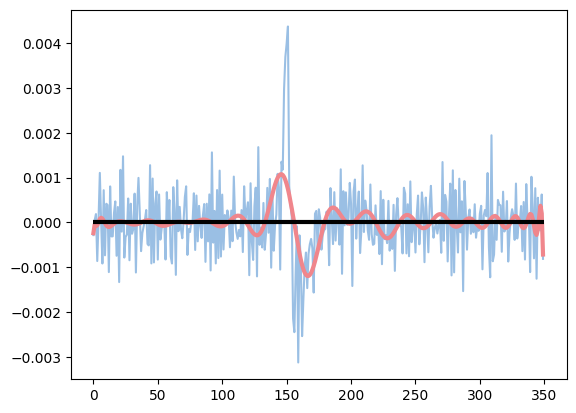

In [318]:
with PdfPages("peth_diff.pdf") as pdf:
    from numpy.polynomial.polynomial import Polynomial
    p = Polynomial.fit(range(350), mean_diff[:350], deg=40) 

    plt.figure()
    plt.plot(range(350), mean_diff[:350], alpha=0.7, color = "#70A5D9")
    plt.plot(range(350), p(range(350)), color='#F0868C',linewidth = 3)
    plt.hlines(y = 0, xmin=0, xmax=350, colors= 'black', linewidth = 3)
    pdf.savefig()
#70A5D9', 'lightgrey', '#F0868C
    #133.19461959  179.40391155

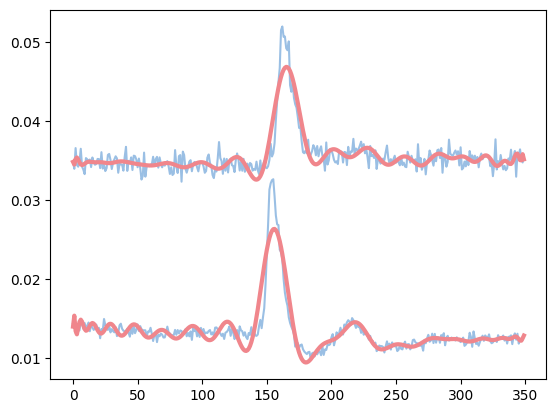

In [353]:
mean_spike_rate_trigger = np.mean(spike_rates_all, axis=0)
mean_spike_rate_22 = np.mean(spike_rates_22, axis= 0)

with PdfPages("peth_diff_22.pdf") as pdf:
    from numpy.polynomial.polynomial import Polynomial
    p = Polynomial.fit(range(350), mean_spike_rate_trigger[:350], deg=40) 
    p_2 = Polynomial.fit(range(350), mean_spike_rate_22[:350], deg=40) 

    plt.figure()
    plt.plot(range(350), mean_spike_rate_trigger[:350], alpha=0.7, color = "#70A5D9")
    plt.plot(range(350), p(range(350)), color='#F0868C',linewidth = 3)


    plt.plot(range(350), mean_spike_rate_22[:350] + 0.03, alpha=0.7, color = "#70A5D9")
    plt.plot(range(350), p_2(range(350)) + 0.03, color='#F0868C',linewidth = 3)
    #plt.hlines(y = 0, xmin=0, xmax=350, colors= 'black', linewidth = 3)
    pdf.savefig()

In [238]:
133.19461959/498 * 20000

5349.181509638554

In [ ]:
from scipy import stats

num_neurons = len(spike_inf['Neuron'].unique())
num_images = 18
result_matrix = np.zeros((num_neurons, num_images), dtype=int)
pvalue_matrix = np.ones((num_neurons, num_images))
diff_matrix = np.ones((num_neurons, num_images))

for image in range(1, 19):
    num = 0
    image_mean_spike_rate_data = []
    for neuron_idx, neuron in enumerate(spike_inf['Neuron'].unique()):

        neuron_df = spike_inf[spike_inf['Neuron'] == neuron]

        dates = trigger_time[trigger_time['image'] == image]['date'].unique()
        date_indices = np.arange(len(dates))  

        spike_rates_first = []
        spike_rates_second = []

        for date in dates:
            trigger_time_temp = trigger_time[(trigger_time['image'] == image) & (trigger_time['date'] == date)]
            all_spikes_first = []
            all_spikes_second = []

            for index, row in trigger_time_temp.iterrows():
                start = row['expand_start'] + 5349
                end = row['expand_start'] + 7205

                filtered_spikes_first = neuron_df[(neuron_df['date'] == date) &
                                                  (neuron_df['time'] >= start) &
                                                  (neuron_df['time'] <= end)]

                if not filtered_spikes_first.empty:
                    relative_spikes_first = filtered_spikes_first['time'] - start
                    all_spikes_first.extend(relative_spikes_first)

                start_2 = row['expand_start'] + 5000 - (7205 - 5349)
                end_2 = row['expand_start'] + 5000

                filtered_spikes_second = neuron_df[(neuron_df['date'] == date) &
                                                   (neuron_df['time'] >= start_2) &
                                                   (neuron_df['time'] <= end_2)]

                if not filtered_spikes_second.empty:
                    relative_spikes_second = filtered_spikes_second['time'] - start_2
                    all_spikes_second.extend(relative_spikes_second)

            if all_spikes_first:
                time_bins_first = np.linspace(0, max(all_spikes_first), 100)
                spike_counts_first, _ = np.histogram(all_spikes_first, bins=time_bins_first)
                spike_rate_first = spike_counts_first / (time_bins_first[1] - time_bins_first[0])
                spike_rates_first.append(spike_rate_first)

            if all_spikes_second:
                time_bins_second = np.linspace(0, max(all_spikes_second), 100)
                spike_counts_second, _ = np.histogram(all_spikes_second, bins=time_bins_second)
                spike_rate_second = spike_counts_second / (time_bins_second[1] - time_bins_second[0])
                spike_rates_second.append(spike_rate_second)

        mean_spike_rate_first = np.mean(spike_rates_first, axis=0) if spike_rates_first else np.zeros(100)
        mean_spike_rate_second = np.mean(spike_rates_second, axis=0) if spike_rates_second else np.zeros(100)

        t_stat, p_value = stats.ttest_ind(mean_spike_rate_first, mean_spike_rate_second, nan_policy='omit')

        if p_value < 0.01:
            if np.mean(mean_spike_rate_first) > np.mean(mean_spike_rate_second):
                result_matrix[neuron_idx, image-1] = 1
                diff_matrix[neuron_idx, image-1] = np.mean(mean_spike_rate_first)/np.mean(mean_spike_rate_second)
            else:
                result_matrix[neuron_idx, image-1] = -1
                diff_matrix[neuron_idx, image-1] = np.mean(mean_spike_rate_second)/np.mean(mean_spike_rate_first)
        else:
            result_matrix[neuron_idx, image-1] = 0
            diff_matrix[neuron_idx, image-1] = 1
        pvalue_matrix[neuron_idx, image-1] = p_value
        


neurons = spike_inf['Neuron'].unique()
images = range(1, 19)
result_df = pd.DataFrame(result_matrix, index=neurons, columns=images)
pvalue_df = pd.DataFrame(pvalue_matrix, index=neurons, columns=images)
diff_df = pd.DataFrame(diff_matrix, index=neurons, columns=images)

result_df.to_csv("glimpse_result_df.csv")
pvalue_df.to_csv("glimpse_pvalue_df.csv")
diff_df.to_csv("glimpse_diff_df.csv")

In [309]:
neurons = result_df.index
images = result_df.columns


with PdfPages('glimpse_neuron_radar_plots_sep.pdf') as pdf:
    for neuron in neurons:
        fig, axes = plt.subplots(1, 3, figsize=(15, 4), subplot_kw={'polar': True})
        axes = axes.flatten()
        
        results = result_df.loc[neuron].values
        diffs = diff_df.loc[neuron].values
        
        image_groups = [images[:6], images[6:12], images[12:]]
        
        for i, ax in enumerate(axes):
            angles = np.linspace(0, 2*np.pi, 6, endpoint=False).tolist()
            
            for j, image in enumerate(image_groups[i]):
                idx = images.get_loc(image)
                result = results[idx]
                diff = diffs[idx]
                
                if diff == 0:
                    height = 0
                else:
                    height = diff
                
                if result == 1:
                    color = "#F9BEB9"
                elif result == 0:
                    color = 'lightgrey'
                else:
                    color = '#AFC7E8'
                
                ax.bar(angles[j], height, width=2*np.pi/6, bottom=0.0, color=color, alpha=0.8)
            
            ax.set_xticks(angles)
            ax.set_xticklabels(image_groups[i])
            ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
            ax.set_axisbelow(True)  
        
        fig.suptitle(f'Neuron {neuron}', x=0.05, y=0.95, va='center', ha='left')
        
        plt.tight_layout()
        
        pdf.savefig()
        plt.close()



In [310]:
from math import pi

result_df = result_df[[1, 7, 13, 2, 8, 14, 3, 9, 15, 4, 10, 16, 5, 11, 17, 6, 12, 18]]
pvalue_df = pvalue_df[[1, 7, 13, 2, 8, 14, 3, 9, 15, 4, 10, 16, 5, 11, 17, 6, 12, 18]]

neurons = result_df.index
images = result_df.columns

all_pvalues = pvalue_df.values.flatten()
all_pvalues = all_pvalues[all_pvalues != 0]  
all_log_pvalues = -np.log(all_pvalues)

with PdfPages('glimpse_neuron_radar_plots.pdf') as pdf:
    for neuron in neurons:
        fig = plt.figure(figsize=(5, 4))
        ax = fig.add_subplot(111, polar=True)
        
        results = result_df.loc[neuron].values
        pvalues = pvalue_df.loc[neuron].values
        
        angles = np.linspace(0, 2*np.pi, len(images), endpoint=False).tolist()
        
        for j, (result, pvalue, image) in enumerate(zip(results, pvalues, images)):
            if pvalue == 0:
                height = 0
            else:
                height = -np.log(pvalue)
            
            if result == 1:
                color = "#F9BEB9"
            elif result == 0:
                color = 'lightgrey'
            else:
                color = '#AFC7E8'
            
            ax.bar(angles[j], height, width=2*np.pi/len(images), bottom=0.0, color=color, alpha=0.8)
                
        ax.set_xticks(angles)
        ax.set_xticklabels(images)
        ax.set_title(neuron, pad=20, x=-0.1)
        
        ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.tick_params(axis='y', labelsize=8)
        plt.tight_layout()
        
        pdf.savefig()
        plt.close()

In [334]:
from matplotlib.colors import ListedColormap

with PdfPages("glimpse_neuron_reaction.pdf") as pdf:
    cmap = ListedColormap(['#70A5D9', 'lightgrey', '#F0868C'])
    plt.figure(figsize=(4, 4))
    ax = sns.heatmap(result_df, cmap=cmap, cbar=True)
    pdf.savefig()
    plt.close()

    cmap = ListedColormap(['#70A5D9', 'lightgrey', '#F0868C'])
    plt.figure(figsize=(4, 4))
    ax = sns.heatmap(result_df, cmap=cmap, cbar=False, linecolor="white",   
    linewidths=0.3)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.axis('off') 
    pdf.savefig()
    plt.close()

    plt.figure(figsize=(4, 4))
    ax = sns.heatmap(-np.log(pvalue_df), cmap='coolwarm', cbar=True, annot=True,fmt='.2f',
    annot_kws={"size": 4})
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.axis('off') 
    pdf.savefig()
    plt.close()

    plt.figure(figsize=(4, 4))
    ax = sns.heatmap(-np.log(pvalue_df), cmap='coolwarm', cbar=False, annot=False,fmt='.2f',
    annot_kws={"size": 4}, vmax=25)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.axis('off') 
    pdf.savefig()
    plt.close()

In [266]:
from scipy import stats

num_neurons = len(spike_inf['Neuron'].unique())
num_images = 18
result_matrix = np.zeros((num_neurons, num_images), dtype=int)
pvalue_matrix = np.ones((num_neurons, num_images))
diff_matrix = np.ones((num_neurons, num_images))

for image in range(1, 19):
    num = 0
    image_mean_spike_rate_data = []
    for neuron_idx, neuron in enumerate(spike_inf['Neuron'].unique()):

        neuron_df = spike_inf[spike_inf['Neuron'] == neuron]

        dates = trigger_time[trigger_time['image'] == image]['date'].unique()
        date_indices = np.arange(len(dates))  

        spike_rates_first = []
        spike_rates_second = []

        for date in dates:
            trigger_time_temp = trigger_time[(trigger_time['image'] == image) & (trigger_time['date'] == date)]
            all_spikes_first = []
            all_spikes_second = []

            for index, row in trigger_time_temp.iterrows():
                start = row['expand_start'] + 7205
                end = row['start'] + 10000 

                filtered_spikes_first = neuron_df[(neuron_df['date'] == date) &
                                                  (neuron_df['time'] >= start) &
                                                  (neuron_df['time'] <= end)]

                if not filtered_spikes_first.empty:
                    relative_spikes_first = filtered_spikes_first['time'] - start
                    all_spikes_first.extend(relative_spikes_first)

                start_2 = row['start'] - (end - start)
                end_2 = row['start'] 

                filtered_spikes_second = neuron_df[(neuron_df['date'] == date) &
                                                   (neuron_df['time'] >= start_2) &
                                                   (neuron_df['time'] <= end_2)]

                if not filtered_spikes_second.empty:
                    relative_spikes_second = filtered_spikes_second['time'] - start_2
                    all_spikes_second.extend(relative_spikes_second)

            if all_spikes_first:
                time_bins_first = np.linspace(0, max(all_spikes_first), 500)
                spike_counts_first, _ = np.histogram(all_spikes_first, bins=time_bins_first)
                spike_rate_first = spike_counts_first / (time_bins_first[1] - time_bins_first[0])
                spike_rates_first.append(spike_rate_first)

            if all_spikes_second:
                time_bins_second = np.linspace(0, max(all_spikes_second), 500)
                spike_counts_second, _ = np.histogram(all_spikes_second, bins=time_bins_second)
                spike_rate_second = spike_counts_second / (time_bins_second[1] - time_bins_second[0])
                spike_rates_second.append(spike_rate_second)

        mean_spike_rate_first = np.mean(spike_rates_first, axis=0) if spike_rates_first else np.zeros(100)
        mean_spike_rate_second = np.mean(spike_rates_second, axis=0) if spike_rates_second else np.zeros(100)

        t_stat, p_value = stats.ttest_ind(mean_spike_rate_first, mean_spike_rate_second, nan_policy='omit')

        if p_value < 1e-3:
            if np.mean(mean_spike_rate_first) > np.mean(mean_spike_rate_second):
                result_matrix[neuron_idx, image-1] = 1
            else:
                result_matrix[neuron_idx, image-1] = -1
        else:
            result_matrix[neuron_idx, image-1] = 0
        pvalue_matrix[neuron_idx, image-1] = p_value
        diff_matrix[neuron_idx, image-1] = np.mean(mean_spike_rate_first)/np.mean(mean_spike_rate_second)


neurons = spike_inf['Neuron'].unique()
images = range(1, 19)
result_df = pd.DataFrame(result_matrix, index=neurons, columns=images)
pvalue_df = pd.DataFrame(pvalue_matrix, index=neurons, columns=images)
diff_df = pd.DataFrame(diff_matrix, index=neurons, columns=images)

result_df.to_csv("last_result_df.csv")
pvalue_df.to_csv("last_pvalue_df.csv")
diff_df.to_csv("last_diff_df.csv")

In [279]:
result_df = result_df[[1, 7, 13, 2, 8, 14, 3, 9, 15, 4, 10, 16, 5, 11, 17, 6, 12, 18]]
pvalue_df = pvalue_df[[1, 7, 13, 2, 8, 14, 3, 9, 15, 4, 10, 16, 5, 11, 17, 6, 12, 18]]

neurons = result_df.index
images = result_df.columns


with PdfPages('last_neuron_radar_plots.pdf') as pdf:
    for neuron in neurons:
        fig = plt.figure(figsize=(5, 4))
        ax = fig.add_subplot(111, polar=True)
        
        results = result_df.loc[neuron].values
        pvalue = pvalue_df.loc[neuron].values
        pvalue = -np.log(pvalue)
        
        angles = np.linspace(0, 2*np.pi, len(images), endpoint=False).tolist()
        
        for j, (result, pvalue, image) in enumerate(zip(results, pvalue, images)):
            if pvalue == 0:
                height = 0
            else:
                height = pvalue
            
            if result == 1:
                color = "#F9BEB9"
            elif result == 0:
                color = 'lightgrey'
            else:
                color = '#AFC7E8'
            
            ax.bar(angles[j], height, width=2*np.pi/len(images), bottom=0.0, color=color)
        
        
        ax.set_xticks(angles)
        ax.set_xticklabels(images)
        ax.set_title(neuron, pad=20, x=-0.1)
        
        ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
        
        plt.tight_layout()
        
        pdf.savefig()
        plt.close()

In [331]:
with PdfPages("last_neuron_reaction.pdf") as pdf:
    cmap = ListedColormap(['#70A5D9', 'lightgrey', '#F0868C'])
    plt.figure(figsize=(4, 4))
    ax = sns.heatmap(result_df, cmap=cmap, cbar=True)
    pdf.savefig()
    plt.close()

    cmap = ListedColormap(['#70A5D9', 'lightgrey', '#F0868C'])
    plt.figure(figsize=(4, 4))
    ax = sns.heatmap(result_df, cmap=cmap, cbar=False, linecolor="white",   
    linewidths=0.3)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.axis('off') 
    pdf.savefig()
    plt.close()

    plt.figure(figsize=(4, 4))
    ax = sns.heatmap(-np.log(pvalue_df), cmap='coolwarm', cbar=True, annot=True,fmt='.2f',
    annot_kws={"size": 4})
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.axis('off') 
    pdf.savefig()
    plt.close()

    plt.figure(figsize=(4, 4))
    ax = sns.heatmap(-np.log(pvalue_df), cmap='coolwarm', cbar=False, annot=False,fmt='.2f',
    annot_kws={"size": 4}, vmin=0, vmax=60)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.axis('off') 
    pdf.savefig()
    plt.close()

In [363]:
result_df_glimpse = pd.read_csv("/media/ubuntu/sda/data/mouse6/output_grating/03_single_neuron/Static/glimpse_result_df.csv").iloc[:, 1:]
result_df_last = pd.read_csv("/media/ubuntu/sda/data/mouse6/output_grating/03_single_neuron/Static/last_result_df.csv").iloc[:, 1:]
result_df_glimpse.columns = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
result_df_last.columns = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]

#result_df_glimpse = result_df_glimpse[[1, 7, 13, 2, 8, 14, 3, 9, 15, 4, 10, 16, 5, 11, 17, 6, 12, 18]]
#result_df_last = result_df_last[[1, 7, 13, 2, 8, 14, 3, 9, 15, 4, 10, 16, 5, 11, 17, 6, 12, 18]]
result_df_glimpse = result_df_glimpse.to_numpy()
result_df_last = result_df_last.to_numpy()